In [1]:
%%capture
!pip install pydna
!pip install teemi
!pip install matplotlib==3.1.3

In [2]:
import IPython.core.display
import pydna
import pydna.primer
import pydna.dseqrecord
import pydna.amplify
import pydna.assembly
import pydna.gel
import pydna.ladders

# 04_1_BUILD_Background_strain


<a target="_blank" href="https://colab.research.google.com/github/hiyama341/teemi/blob/main/colab_notebooks/04_1_BUILD_Background_strain.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [3]:
!git clone https://github.com/hiyama341/G8H_CPR_library.git

fatal: destination path 'G8H_CPR_library' already exists and is not an empty directory.


## 0. Intro : Making the Background strain - MIA-HA-1

In this study, we aim to use the previously constructed CRISPR plasmid to generate a background strain through in-vivo assembly. This method utilizes the natural recombination machinery of the host organism to assemble the plasmid in vivo. By introducing the plasmid into the host organism, the recombination machinery will mediate the integration of the plasmid into the host genome. This allows for a high-efficiency and highly precise integration of the plasmid, minimizing the potential for errors and off-target effects.

In-vivo assembly is a powerful method for generating a background strain, as it allows for the precise and efficient integration of the plasmid into the host genome. This will enable us to generate a background strain with a well-defined genetic makeup that can be used for downstream experimentation and validation. Additionally, using this method will avoid the need of using traditional cloning methods, which can be time-consuming and error-prone. This will result in a more reliable and efficient generation of the background strain and will provide a strong foundation for our study.





## Project overview 
 
Hypothesis
1. Specific combinations of CPR / G8H homologs and corresponding expression levels can remove the G8H bottleneck in the Strictosidine pathway

Aim: To test the hypothesis

Tasks
1. dgRNA 
2. **Base strain**
    - From de novo producer (MIA-CH-A2 )
    - MIA-HA-1 (MIA-CH-A2 - KO --> CroCPR - CroG8H)
3. Library
4. Phenotyping
5. Data analysis

# 1. Base strain

Import the base strain we are gonna work with

In [4]:
from Bio import SeqIO

In [5]:
CH_A2 = SeqIO.read('G8H_CPR_library/data/03-strain_sequences/background_and_controls/MIA-CH-A2.gb', format= 'gb')

In [6]:
CH_A2

SeqRecord(seq=Seq('CTCTCAGCTTATTAGCGCACTAAAGAGTCAGTTTGGGTGAATAGCGTAATCAAC...CAC'), id='seq_PaecbGRu', name='MIA-CH-A2', description='', dbxrefs=[])

# 2. dgRNA

In [7]:
from teemi.lims.csv_database import get_database, get_dna_from_plate_name, get_dna_from_box_name
from pydna.dseqrecord import Dseqrecord

In [8]:
# retrive the gRNA_ATF1_CroCPR plasmid we made in the previous notebook
gRNA_ATF1_CroCPR = Dseqrecord(get_dna_from_plate_name('pCfB-56(pESC-LEU-gRNA_ATF1-CroCPR).fasta', 'plasmid_plates', database_path= 'G8H_CPR_library/data/06-lims/csv_database/'))
gRNA_ATF1_CroCPR.name = 'pCfB-56(pESC-LEU-gRNA_ATF1-CroCPR)'
gRNA_ATF1_CroCPR.annotations

{'plate': 0,
 'row': 'A',
 'col': 5,
 'batches': [{'location': 'plasmid_plates_0_A5',
   'volume': 134.0,
   'concentration': 103.0}],
 'molecule_type': 'DNA'}

# 3. Repair templates

Repair templates: 
- G8H; tADH1-P1_PGK1_400
- CPR; XI-3 (l4_A08)

### **3.1 - G8H**

| Part | Template | Primer_Fw | Primer_Rv | Anneal | Size |
| --- | --- | --- | --- | --- | --- |
| tADH1-P1_PGK1_400 | pRS413U_P2_PGK1_mKate2 | pPGK1_Seq_Rv |USER_XhoI_Fw| Touchdown | 0.6 kb |

In [9]:
pRS413U_P2_PGK1_mKate2 = get_dna_from_plate_name('PL_02_E2(pRS413U-P2_PGK1-mKate2.fasta', 'plasmid_plates', database_path='G8H_CPR_library/data/06-lims/csv_database/')
USER_XhoI_Fw = get_dna_from_box_name('USER_XhoI_Fw', 'primer_box', database_path='G8H_CPR_library/data/06-lims/csv_database/')
pPGK1_Seq_Rv = get_dna_from_box_name('pPGK1_Seq_Rv', 'primer_box', database_path='G8H_CPR_library/data/06-lims/csv_database/')

In [10]:
# amplifying the ATF1 repair template
ATF1_repair_template = pydna.amplify.pcr(pPGK1_Seq_Rv, USER_XhoI_Fw, pRS413U_P2_PGK1_mKate2)
ATF1_repair_template

Amplicon(659)

Updating locations:

### **3.2 - CPR**

| Part | Template | Primer_Fw | Primer_Rv | Anneal | Size |
| --- | --- | --- | --- | --- | --- |
| XI-3 | gDNA | XI-3- up-out-sq |XI-3- down-out-sq| Touchdown | 1.4 kb |





In [11]:
# We can get the template from genomic DNA
XIChromosomeSeq = SeqIO.read('G8H_CPR_library/data/03-strain_sequences/chromosome_files/11.fa', "fasta")
XIChromosomeSeq.annotations['batches'] = []
XIChromosomeSeq.annotations['batches'].append({'location':"l4_A01"})

In [12]:
# Retrieve the sequences from the database
XI_3_up_out_sq = get_dna_from_box_name('XI-3-up-out-sq', 'primer_box', database_path="G8H_CPR_library/data/06-lims/csv_database/")
XI_3_down_out_sq = get_dna_from_box_name('XI-3- down-out-sq', 'primer_box', database_path="G8H_CPR_library/data/06-lims/csv_database/")

In [13]:
# Amplifying the CPR repair template
CPR_repair_template = pydna.amplify.pcr(XI_3_up_out_sq,XI_3_down_out_sq, XIChromosomeSeq)

# 4. PCR reactions

In [14]:
from teemi.build.PCR import pcr_locations, calculate_volumes

In [15]:
pcr_locations([ATF1_repair_template, CPR_repair_template])

location             name             template  \
0  plasmid_plates_0_A4   659bp_PCR_prod  plasmid_plates_0_A4   
1               l4_A01  1449bp_PCR_prod               l4_A01   

                     fw                    rv  
0  primer_box_rack_2_A1  primer_box_rack_2_A7  
1  primer_box_rack_2_A5  primer_box_rack_2_A2

In [16]:
calculate_volumes(vol_p_reac = 50, 
        no_of_reactions = 3,
        standard_reagents = ["Template", "Primer 1", "Primer 2", "H20", "Pol"],
        standard_volumes = [1, 2.5, 2.5, 19, 25])

vol_p_reac  vol_p_3_reac
Template         1.0           3.0
Primer 1         2.5           7.5
Primer 2         2.5           7.5
H20             19.0          57.0
Pol             25.0          75.0
Total           50.0         150.0

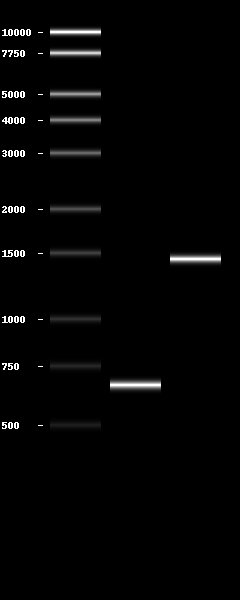

In [17]:
pydna.gel.gel([pydna.ladders.PennStateLadder,[ATF1_repair_template],[CPR_repair_template]]) #GeneRuler_1kb_; [Dseqrecord("A"*2000)]

For each PCR:
- Physically (eventually using robots):
    - Mix
    - Run thermocycler
    - Run gel
    - Determine purification method and elution volume
    - Purify
    - Measure concentration on nanodrop
    - Label container, transfer purified PCR to container, place container at given location.

For each PCR:
- Digitally (using benchlingapi):
    - Create a batch with concentration and volume and place in container

In [18]:
from teemi.lims.csv_database import add_annotations, get_unique_id, add_sequences_to_dataframe, update_database

In [19]:
# Adding annotations
ATF1_repair_template = add_annotations([ATF1_repair_template], volume = 50.0 , concentration = 123.6, location = 'l5_A02', comments = 'ATF1_repair_template to KO G8H module')
ATF1_repair_template = ATF1_repair_template[0]

# changing name and adding location
ATF1_repair_template.name = "tADH1-P1_PGK1_400"

# getting a unique id from the databse
ATF1_repair_template.id =  get_unique_id(path='G8H_CPR_library/data/06-lims/csv_database/' )

# add the PCR_to the pcr_box
pcr_box = get_database('PCR_box', path="G8H_CPR_library/data/06-lims/csv_database/")
add_sequences_to_dataframe([ATF1_repair_template], pcr_box)

## ALready updated database
#update_database(pcr_box, 'PCR_box', path ="G8H_CPR_library/Data/csv_database/" )

In [20]:
# Adding annotations
CPR_repair_template = add_annotations([CPR_repair_template], volume = 50.0 , concentration = 93, location = 'l4_A08', comments = 'CPR_repair_template to KO CPR module')
CPR_repair_template = CPR_repair_template[0]

# changing name and adding location
CPR_repair_template.name = "XI-3"

# getting a unique id from the databse
CPR_repair_template.id =  get_unique_id(path='G8H_CPR_library/data/06-lims/csv_database/' )

# add the PCR_to the pcr_box
pcr_box = get_database('PCR_box', path="G8H_CPR_library/data/06-lims/csv_database/")
add_sequences_to_dataframe([CPR_repair_template], pcr_box)

## ALready updated database
#update_database(pcr_box, 'PCR_box', path ="G8H_CPR_library/Data/csv_database/" )
pcr_box.head(4)

ID               name        date  box row  col    size  \
0  10162.0               ATF1  09-06-2022    0   A    1   425.0   
1  10163.0             CroCPR  09-06-2022    0   A    2   425.0   
2  10165.0  tADH1-P1_PGK1_400  09-12-2022    0   A    3   659.0   
3  10168.0               XI-3  09-22-2022    0   A    4  1449.0   

                                                 seq  concentration  volume  \
0  CGTGCGATTCTTTGAAAAGATAATGTATGATTATGCTTTCACTCAT...           57.0    50.0   
1  AGTGCAGGTTCTTTGAAAAGATAATGTATGATTATGCTTTCACTCA...           63.0    50.0   
2  ACTCTCGAGAGCGACCTCATGCTATACCTGAGAAAGCAACCTGACC...          123.6    50.0   
3  GTGCTTGATTTGCGTCATTCATTACCATAGTATTACTATTGGTGTT...           93.0    50.0   

                                            features location reference  \
0  [SeqFeature(FeatureLocation(ExactPosition(0), ...   l4_I07       NaN   
1  [SeqFeature(FeatureLocation(ExactPosition(8), ...   l4_I08       NaN   
2  [SeqFeature(FeatureLocation(ExactPosition(3), ...   l5_A02       NaN   
3  [SeqFeature(FeatureLocation(ExactPosition(0), ...   l4_A08       NaN   

                                comments  \
0          gRNA with ATF1 site to KO G8H   
1        gRNA with croCPR site to KO G8H   
2  ATF1_repair_template to KO G8H module   
3   CPR_repair_template to KO CPR module   

                                         description  
0  pcr_product_Stock of primers for G8H-CPR libra...  
1  pcr_product_Stock of primers for G8H-CPR libra...  
2  pcr_product_Stock of primers for G8H-CPR libra...  
3  pcr_product_Stock of primers for G8H-CPR libra...

# 5. Assemblies

In this section we want to simmulate the assembly the double knock-out strain with the repair templates. 



| Name | Parent | gRNA (500 ng) | Parts (300 ng) |
| --- | --- | --- | --- |
| MIA-HA-1 | CH-A2 | pESC-LEU-gRNA_ATF1-CroCPR | tADH1-P1_PGK1_400, XI-3 | 

In [21]:
ATF1_gRNA = Dseqrecord("GAATGGGCATGCTCGGCGTA", name = "ATF1") # cuts X-3
CroCPR_gRNA = Dseqrecord("GCCGTAGTAACGTCGCTGTC", name = "CroCPR") #CroCPR gRNA-2 # cuts XI-3

In [22]:
ATF1_repair_template.template.id = str(ATF1_repair_template.template.id)
CPR_repair_template.template.id = str(CPR_repair_template.template.id)

In [23]:
ATF1_repair_template.id = str(ATF1_repair_template.id)
CPR_repair_template.id = str(CPR_repair_template.id)

In [24]:
parameters = {
'bg_strain': CH_A2,
'site_names': ["X-3", "XI-3"],
'gRNAs': [ATF1_gRNA, CroCPR_gRNA],
'parts': [[ATF1_repair_template],[CPR_repair_template]],
'assembly_limits':[200,400],
'assembly_names': ["X_3_tADH1_P2_pPGK1", "XI_3_UP_DW"],
'verbose': False,
'to_benchling': False  
}

In [25]:
from teemi.design.cloning import casembler

In [26]:
# This one doesnt work with fasta files
HA1 = casembler(**parameters)

In [27]:
HA1.name = "MIA-HA-1"
HA1.annotations['batches'] = []
HA1.annotations['batches'].append({'location':'y01_D08'})

In [28]:
HA1

Dseqrecord(-4766)

# 6. Transformation reactions


Protocol for transformation:

[Yeast transformation protocol](G8H_CPR_library/methods/methods.ipynb)

Assumptions:
- Transformation time: 9 (aka time when the target OD is reached)


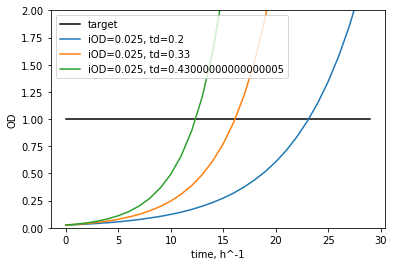

Hours to target OD: 	16 hours
Transformation time has been set to  9
Time of inoculation: 	-1 day, 17:00:00 (aka when to start growing the cells)

NB: If you inoculated now, the cells will have reached the target OD by:   2023-06-11 01:42:41.615134


In [29]:
from teemi.build.transformation import time_to_inoculate, ng_to_nmol, transformation_mix
time_to_inoculate(initialOD = 0.025, td=0.33, verbose= False, transformation_time = 9, target_OD = 1)

In [30]:
# IMPORT POSITIVE CONTROL
LEU_plasmid = get_dna_from_plate_name('LEU_plasmid.fasta', 'plasmid_plates', database_path="G8H_CPR_library/data/06-lims/csv_database/")

# and name
LEU_plasmid.name = "pMIA_042_Cro_CPR_in_pRS415_USER_(leu)_-_TEF1"

In [31]:
reaction_names = [HA1.name + "(MIA-CH-A2-CPR-G8H)", 
                  "n.ctr", "n.ctr", "n.ctr", "p. ctr"]

In [32]:
reaction_participants = [[gRNA_ATF1_CroCPR, ATF1_repair_template,CPR_repair_template],
                         [gRNA_ATF1_CroCPR],
                         [gRNA_ATF1_CroCPR, ATF1_repair_template],
                         [gRNA_ATF1_CroCPR, CPR_repair_template], 
                         [LEU_plasmid]]

In [33]:
nmol_gRNA = ng_to_nmol(ng = 500, bp = len(gRNA_ATF1_CroCPR))
nmol_gRNA

9.865727449413482e-05

In [34]:
nmol_pctr = ng_to_nmol(ng = 10, bp = len(LEU_plasmid))
nmol_pctr

2.248883991319308e-06

In [35]:
# in nmol
wanted_amounts = {'pCfB-56(pESC-LEU-gRNA_ATF1-CroCPR)' : nmol_gRNA,                 # Double gRNA plasmid
                         'tADH1-P1_PGK1_400'                  : 0.0001,             # G8H repair
                         'XI-3'                               : 0.0001,             # CPR repair
                         'pMIA_042_Cro_CPR_in_pRS415_USER_(leu)_-_TEF1': nmol_pctr} # LEU_plasmid

In [36]:
media = ['SC-LEU'] * 5

In [37]:
transformation_mix(reaction_names, reaction_participants, wanted_amounts = wanted_amounts, water_dna_p_reac = 18.5, media = media)

name  pCfB-56(pESC-LEU-gRNA_ATF1-CroCPR)  \
0  MIA-HA-1(MIA-CH-A2-CPR-G8H)                                 4.9   
1                        n.ctr                                 4.9   
2                        n.ctr                                 4.9   
3                        n.ctr                                 4.9   
4                       p. ctr                                 NaN   

   tADH1-P1_PGK1_400  XI-3  pMIA_042_Cro_CPR_in_pRS415_USER_(leu)_-_TEF1  \
0                0.3   1.0                                           NaN   
1                NaN   NaN                                           NaN   
2                0.3   NaN                                           NaN   
3                NaN   1.0                                           NaN   
4                NaN   NaN                                           0.1   

   water plate on  
0   12.3   SC-LEU  
1   13.6   SC-LEU  
2   13.3   SC-LEU  
3   12.6   SC-LEU  
4   18.4   SC-LEU

In [38]:
calculate_volumes(vol_p_reac = 90, 
        no_of_reactions = 6,
        standard_reagents = ["PEG", "LiAc_1M", "ssDNA", "water_dna"],
        standard_volumes = [240, 36, 10, 74])

vol_p_reac  vol_p_6_reac
PEG              60.0         360.0
LiAc_1M           9.0          54.0
ssDNA             2.5          15.0
water_dna        18.5         111.0
Total            90.0         540.0


The picture below is showing what a succesfull experiment should look like with: 
1. CRISPR_plasmid and repair templates
2. Negative control: CRISPR_plasmid
3. Negative control: CRISPR_plasmid and one repair template        (gRNA_ATF1_CroCPR, ATF1_repair_template)
4. Negative control: CRISPR_plasmid and one repair template        (gRNA_ATF1_CroCPR, CPR_repair_template)
5. Positive control: LEU plasmid

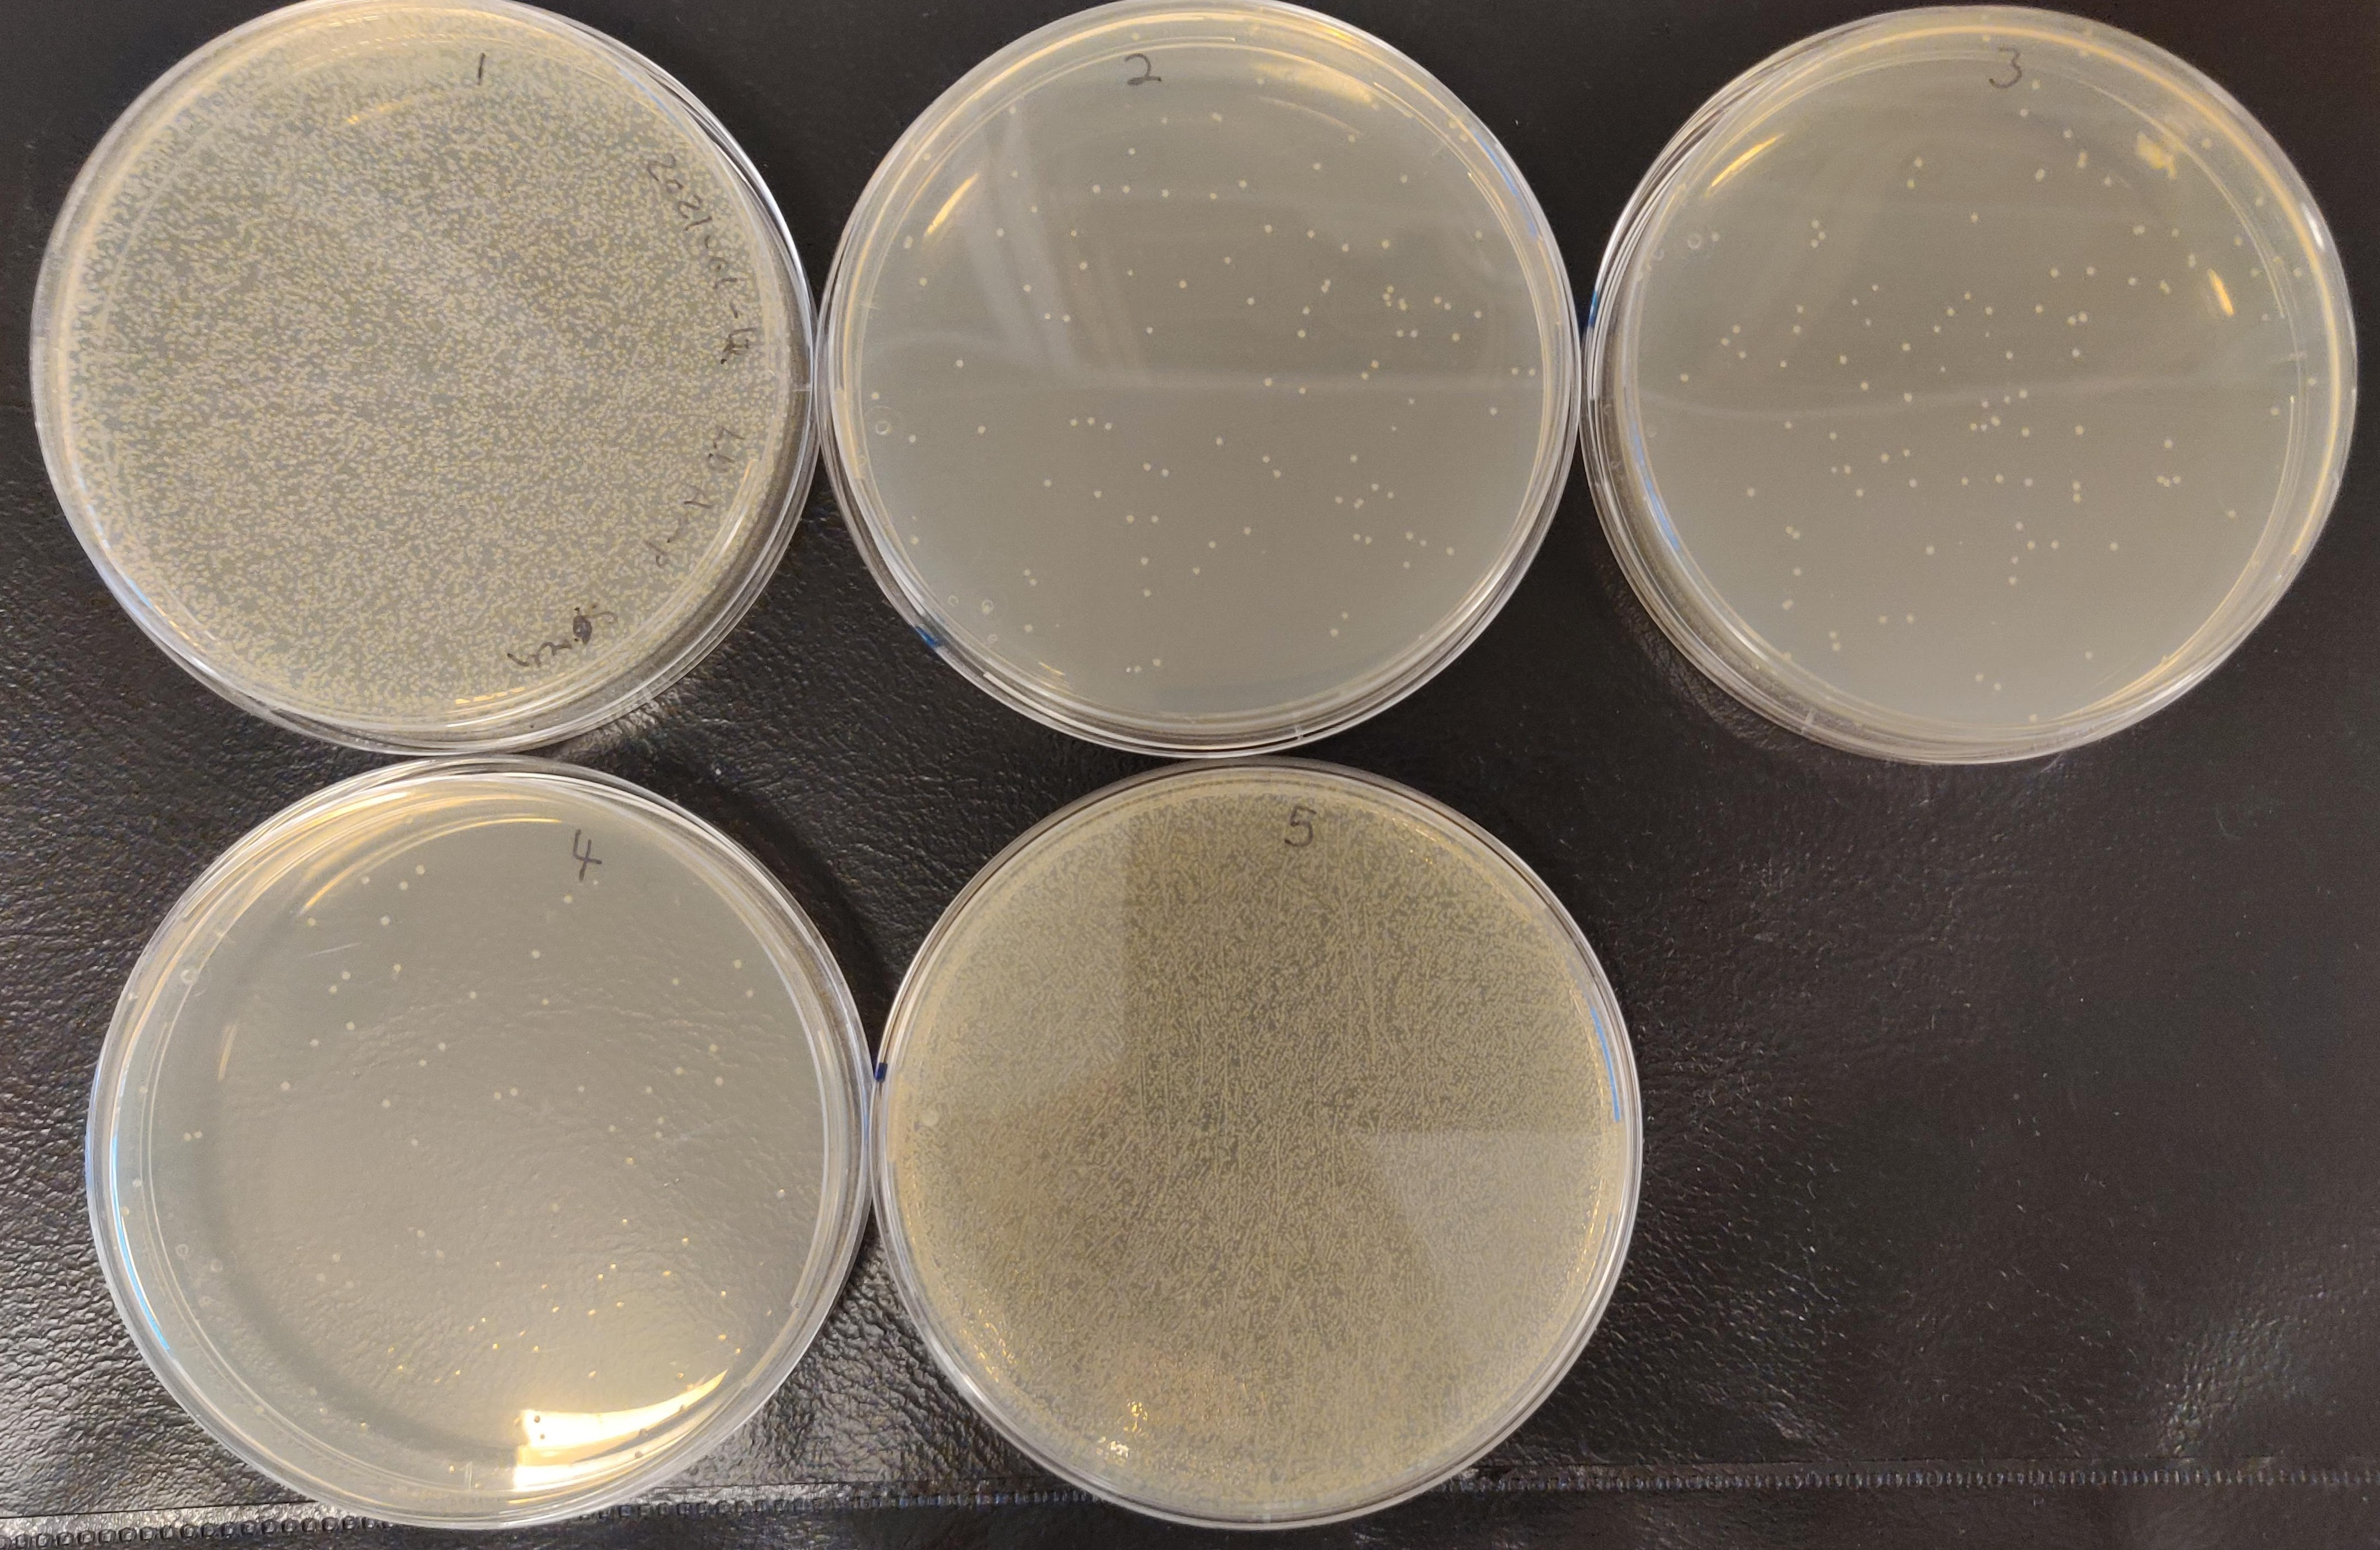

In [39]:
IPython.core.display.Image('G8H_CPR_library/data/05-gel_bioimager_nanophotometer/raw/bioimager/dgRNA ATF1 and CroCPR.jpg', width=600)

The picture below is the actual picture from the transformation: 

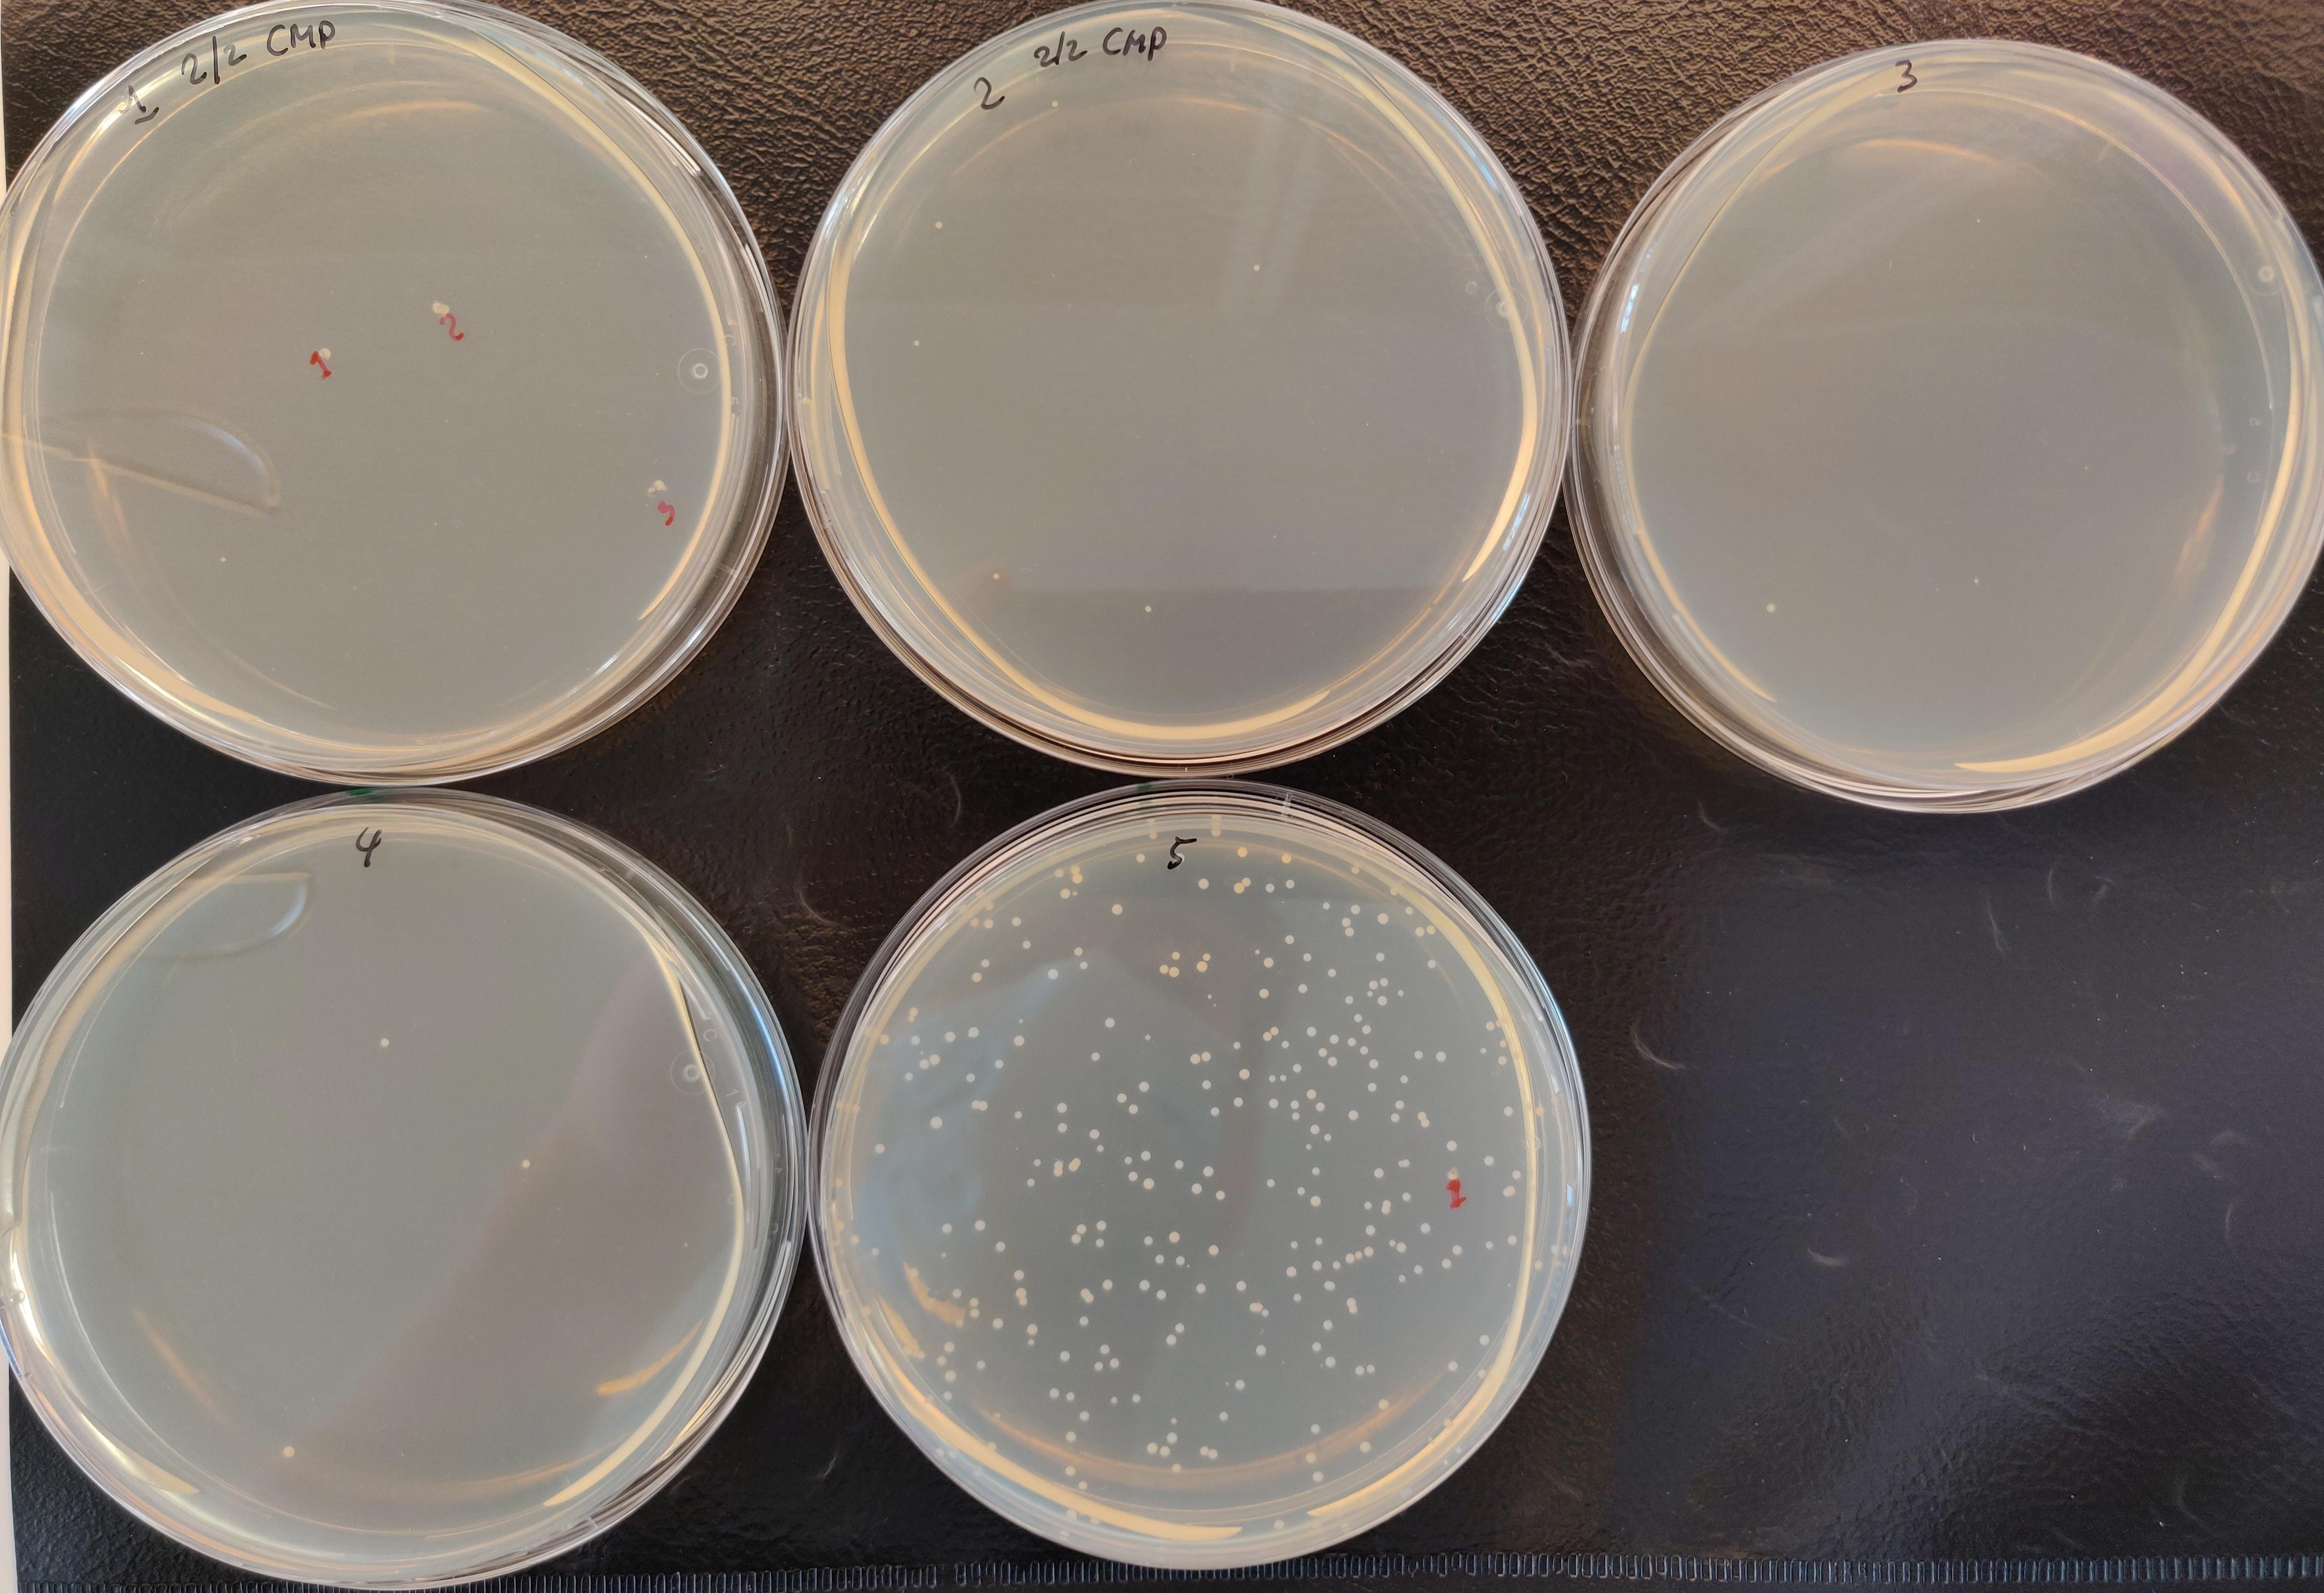

In [40]:
IPython.core.display.Image('G8H_CPR_library/data/05-gel_bioimager_nanophotometer/raw/doc_it _imaging_station/2021-02-09_transformation_plates.jpg', width=600)

Before transformation:
- MIA-CH-A2 Doubling time is ~ 3h in YPD. WT is ~2h. This is also observed by Sam and Beata for MIA-CH-A2.

After transformation:

1. Few colonies on all plates. This sometime happens with slow growing strains. Probably due to combination of cells less viable and generally less cells used for transformation. If we repeat, scale reaction to 360 µl, 5 ml OD 1 culture per transformation, 0.5 pmol DNA (repair templates), 500 ng gRNA

2. Few colonies on plate # 1: Worry that we do not see more colonies on plate # 1 compared to 2, 3,and 4. 
- Viability probably decreased by accumulation of toxic geraniol due to G8H knockout (see figure below) 
- I can't tell by any geraniol smell whether the knockout worked. 

Next step:
- Genotype all colonies on plate # 1. 
- If the plate#1 colonies are not correct we may switch to MIA-CH-A2. What do you think?

# 7. Genotyping

Procedure: 

1. Pick 3 colonies from plate#1 and 1 colony from plate#5 (positive control)
2. Yeast DNA extraction for PCR
3. Colony PCR


## 7.1 Colony PCR reactions

### 7.1.1 CroG8H

In [41]:
from teemi.lims.csv_database import get_dna_from_box_name
from teemi.design.cloning import extract_sites

In [42]:
# RETRIEVING PRIMERS
X_3_up_out_sq = get_dna_from_box_name('X_3_up_out_sq', 'primer_box',  database_path="G8H_CPR_library/data/06-lims/csv_database/")
pPGK1_Seq_Rv = get_dna_from_box_name('pPGK1_Seq_Rv', 'primer_box',  database_path="G8H_CPR_library/data/06-lims/csv_database/")
pTDH3_Seq = get_dna_from_box_name('pTDH3_Seq', 'primer_box',  database_path="G8H_CPR_library/data/06-lims/csv_database/")

Extracting the integration site

In [43]:
CH_A2.annotations['location'] = "unknown"
X_3 = extract_sites(["X-3"], [CH_A2],["X-3"])[0]
X_3

SeqRecord(seq=Seq('TGACGAATCGTTAGGCACAGTTATATAGTTATATACACATAGACATACATATGT...CGG'), id='seq_PaecbGRu', name='X-3', description='', dbxrefs=[])

In [44]:
X_3.annotations['batches'] = [{'location': 'l4_A01'}]

In [45]:
X_3.annotations

{'topology': 'linear',
 'data_file_division': 'PLN',
 'date': '05-MAR-2021',
 'accessions': ['seq_PaecbGRu'],
 'keywords': [''],
 'source': '',
 'organism': '.',
 'taxonomy': [],
 'molecule_type': 'DNA',
 'location': 'unknown',
 'batches': [{'location': 'l4_A01'}]}

### 7.1.2 CroCPR

retrieving primers

In [46]:
outside_XI_3_ie_911 = get_dna_from_box_name('XI-3-up-out-sq', 'primer_box',  database_path="G8H_CPR_library/data/06-lims/csv_database/")
outside_XI_3_ie_912 = get_dna_from_box_name('XI-3- down-out-sq', 'primer_box',  database_path="G8H_CPR_library/data/06-lims/csv_database/")
CroCPR_U_Rv = get_dna_from_box_name('CroCPR_U_Rv', 'primer_box',  database_path="G8H_CPR_library/data/06-lims/csv_database/")
outside_XI_3_ie_911.annotations

{'box': 2,
 'row': 'A',
 'col': 5,
 'batches': [{'location': 'primer_box_rack_2_A5',
   'volume': nan,
   'concentration': nan}]}

In [47]:
# Lets extract the sites
XI_3 = extract_sites(["XI-3"], [CH_A2],["XI-3"])[0]
XI_3.annotations['batches'] = [{'location': 'l4_A01'}]


In [48]:
len(X_3.seq)

5504

Simulating PCRs

In [49]:
G8H_1_1     = pydna.amplify.pcr(X_3_up_out_sq, pPGK1_Seq_Rv, HA1) #  G8H_ko_band
G8H_1_2     = pydna.amplify.pcr(X_3_up_out_sq, pPGK1_Seq_Rv, HA1) #  G8H_ko_band
G8H_1_3     = pydna.amplify.pcr(X_3_up_out_sq, pPGK1_Seq_Rv, HA1) #  G8H_ko_band
CPR_1_1     = pydna.amplify.pcr(outside_XI_3_ie_911, outside_XI_3_ie_912, HA1) # = CPR_ko_band
CPR_1_2     = pydna.amplify.pcr(outside_XI_3_ie_911, outside_XI_3_ie_912, HA1) # = CPR_ko_band
CPR_1_3     = pydna.amplify.pcr(outside_XI_3_ie_911, outside_XI_3_ie_912, HA1) # = CPR_ko_band
nCtrG8H_5_1 = pydna.amplify.pcr(pTDH3_Seq, pPGK1_Seq_Rv, HA1) # G8H_no_ko_band
nCtrCPR_5_1 = pydna.amplify.pcr(outside_XI_3_ie_911, CroCPR_U_Rv, HA1) # = CPR_no_ko_band 

In [50]:
col_nos   = [1,2,3,1,2,3,1,1]
plate_nos = [1,1,1,1,1,1,5,5]
templates = [str(p_no) + "_" + str(c_no) for p_no, c_no in zip(plate_nos,col_nos)]

In [51]:
descriptions = ["G8HKoBand"] * 3 + ["CPRKoBand"] * 3 + ['G8HnoKoBand'] + ['CPRnoKoBand']

In [52]:
bands = [G8H_1_1, G8H_1_2, G8H_1_3, CPR_1_1, CPR_1_2, CPR_1_3] + [nCtrG8H_5_1, nCtrCPR_5_1]

In [53]:
for band, desc, temp in zip(bands,descriptions, templates):
    band.name = desc + "-" + temp
    band.annotations['batches'] = [{'location':''}]
    band.annotations['template_location'] = temp

Explanation:

| | name | Template |
|---|---|---|
|#|name-template|colony # Y from 2021-02-02 plate # X, X_Y|

In [54]:
pcr_locations(bands)

location             name template                    fw  \
0  y01_D08    G8HKoBand-1_1  y01_D08  primer_box_rack_2_B4   
1  y01_D08    G8HKoBand-1_2  y01_D08  primer_box_rack_2_B4   
2  y01_D08    G8HKoBand-1_3  y01_D08  primer_box_rack_2_B4   
3  y01_D08    CPRKoBand-1_1  y01_D08  primer_box_rack_2_A5   
4  y01_D08    CPRKoBand-1_2  y01_D08  primer_box_rack_2_A5   
5  y01_D08    CPRKoBand-1_3  y01_D08  primer_box_rack_2_A5   
6  y01_D08  G8HnoKoBand-5_1  y01_D08  primer_box_rack_2_B5   
7  y01_D08  CPRnoKoBand-5_1  y01_D08  primer_box_rack_2_A5   

                     rv  
0  primer_box_rack_2_A7  
1  primer_box_rack_2_A7  
2  primer_box_rack_2_A7  
3  primer_box_rack_2_A2  
4  primer_box_rack_2_A2  
5  primer_box_rack_2_A2  
6  primer_box_rack_2_A7  
7  primer_box_rack_2_B6

PCR
- Polymerase: Onetaq (1min / kb) 
- Program: Touchdown
- Elongation time: 1.5 min
- Annealing temp 52/46

In [55]:
calculate_volumes(vol_p_reac = 20, 
        no_of_reactions = len(bands) + 1,
        standard_reagents = ["Template", "Primer 1", "Primer 2", "H20", "Pol"],
        standard_volumes = [2.5, 2.5, 2.5, 19, 25])

vol_p_reac  vol_p_9_reac
Template    0.970874      8.737864
Primer 1    0.970874      8.737864
Primer 2    0.970874      8.737864
H20         7.378641     66.407767
Pol         9.708738     87.378641
Total      20.000000    180.000000

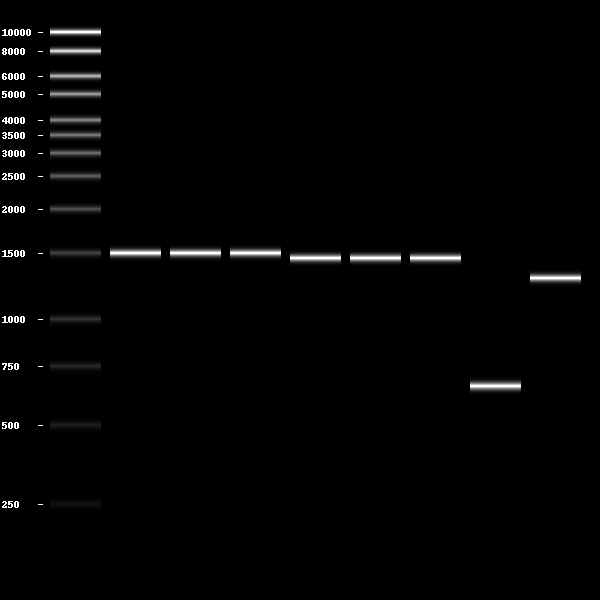

In [56]:
pydna.gel.gel([pydna.ladders.GeneRuler_1kb,*[[band] for band in bands]]) #GeneRuler_1kb_

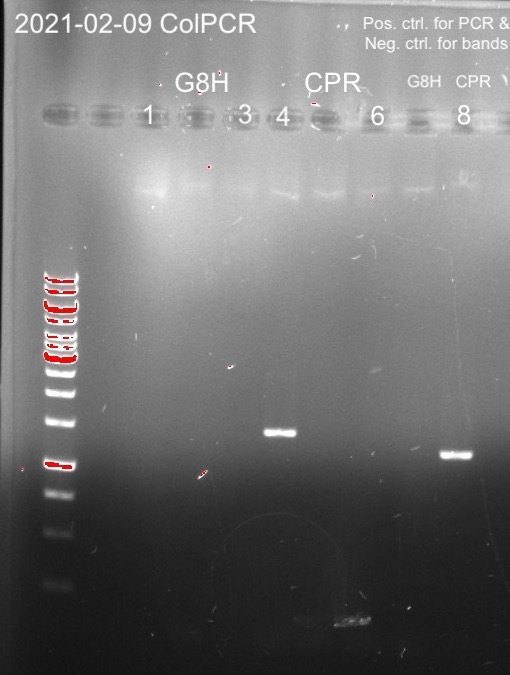

In [57]:
IPython.core.display.Image( 'G8H_CPR_library/data/05-gel_bioimager_nanophotometer/processed/bioimager/2021-02-09 PCR_edited.jpg', width=300)

Colony no. 1 has CPR knockout band. CPR gRNA + repair template worked!.
Colony no. 4 has CPR noknockout band. 

No G8H bands. Why didn't G8H produce band for colony no.4 (well no. 7; negative control)?

Troubleshooting.
- template, polymerase, elongation time all worked for CPR

- Primers
    - primers sequences? 
        - Jie shown they work in MIA-CH-A2.
        - Redilute from stock!
- Program
    - primer annealing temperature?
        - 46/47 C (NEB). No unspecific bands. Decrease to 50/44
    - elongation time
        - Unlikely problem that 1.5 shouldn't work while 1.4 kb CPR band worked. But increase to 1:45 to make sure
- Template
    - Clear gDNA bands for all wells. Lower template volume to 0.4.
    - Try MIA-CM-3 gDNA from Beata. If works primers and program are off suspicion and only templates are in.

Additional comments:
- Run gel 5 min shorter time (~ 25 min) to lighten ~ 500 bp part of gel.

## 7.2 Re-running PCR's

In [58]:
nCtrG8H_Beata = pydna.amplify.pcr(pTDH3_Seq, pPGK1_Seq_Rv, HA1) # G8H_no_ko_band
nCtrG8H_Beata.name = "G8HnoKoBand" + "-" + "MIA-CH-A2_Beata"
nCtrG8H_Beata.annotations['batches'] = [{'location':''}]
nCtrG8H_Beata.annotations['template_location'] = "MIA-CH-A2_Beata"

In [59]:
troubleshooting_bands = [G8H_1_1, G8H_1_2, G8H_1_3] + [nCtrG8H_5_1] + [nCtrG8H_Beata]
troubleshooting_bands

[Amplicon(1498), Amplicon(1498), Amplicon(1498), Amplicon(658), Amplicon(658)]

In [60]:
pcr_locations(troubleshooting_bands)

location                         name template                    fw  \
0  y01_D08                G8HKoBand-1_1  y01_D08  primer_box_rack_2_B4   
1  y01_D08                G8HKoBand-1_2  y01_D08  primer_box_rack_2_B4   
2  y01_D08                G8HKoBand-1_3  y01_D08  primer_box_rack_2_B4   
3  y01_D08              G8HnoKoBand-5_1  y01_D08  primer_box_rack_2_B5   
4  y01_D08  G8HnoKoBand-MIA-CH-A2_Beata  y01_D08  primer_box_rack_2_B5   

                     rv  
0  primer_box_rack_2_A7  
1  primer_box_rack_2_A7  
2  primer_box_rack_2_A7  
3  primer_box_rack_2_A7  
4  primer_box_rack_2_A7

PCR
- Polymerase: Onetaq (1min / kb) 
- Program: Touchdown
- Elongation time: 2 min
- Annealing temp 50/46

In [61]:
calculate_volumes(vol_p_reac = 20, 
        no_of_reactions = len(troubleshooting_bands) + 1,
        standard_reagents = ["Template", "Primer 1", "Primer 2", "H20", "Pol"],
        standard_volumes = [1, 2.5, 2.5, 19, 25])

vol_p_reac  vol_p_6_reac
Template         0.4           2.4
Primer 1         1.0           6.0
Primer 2         1.0           6.0
H20              7.6          45.6
Pol             10.0          60.0
Total           20.0         120.0

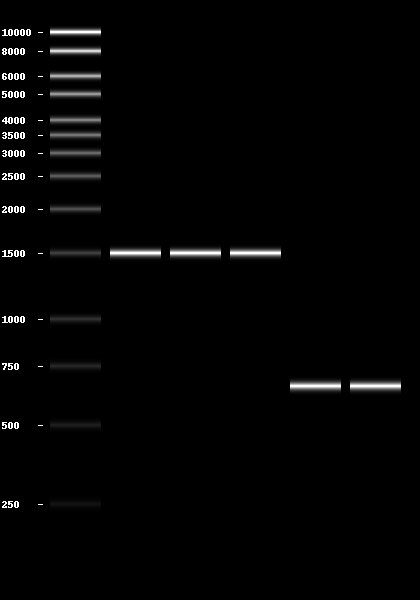

In [62]:
pydna.gel.gel([pydna.ladders.GeneRuler_1kb,*[[band] for band in troubleshooting_bands]]) #GeneRuler_1kb_

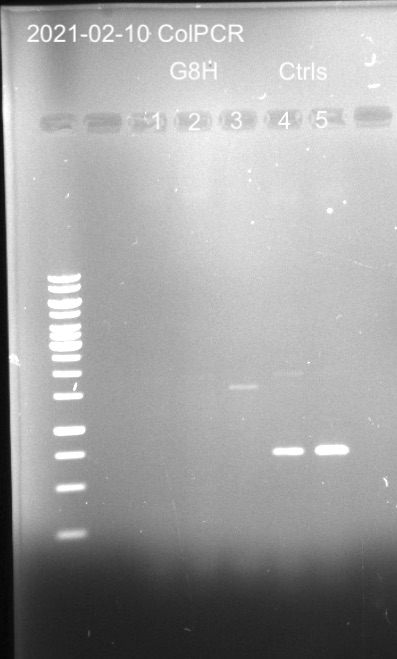

In [63]:
IPython.core.display.Image('G8H_CPR_library/data/05-gel_bioimager_nanophotometer/processed/bioimager/2021-02-10 ColPCR.jpg', width=300)

Observations:
- The G8H colony PCR is working
- Colony no. 4 and MIA-CM-3 gDNA from Beata now shows negative band
- Colony no. 3 shows weak knockout band!
- This means that our gRNA cutting and repair also worked for the G8H site aswell as for CPR!
- PCR still fails for colony no 1, and 2 (no "knockout" or "no knockout" bands)

Troubleshooting:
- primers, polymerase, program works

- template
    - Likely the problem. Improve template quality by reinoculating and using thermo fisher yeast dna extraction kit
    
- If too little repair template was added the strain may looped out the entire integration site in which case the primers can't bind and no band would be observed.
    - unlikely to happen for both integration sites

The combined results for our two colony PCR's are the following .
For colony #:
1. One CPR "knockout band"
3. One G8H "knockout band"
4. (Background strain i.e. ctrl) One G8H and one CPR "no knockout band".
- None of the three colonies has been confirmed to have "incorrect" genotype

Next steps:
1. Inoculate 6 colonies from plate # 1 (1-3 (the ones already used) + 3 colonies (hidden on the edge of the plate)) in 5 ml YPD
2. gDNA prep cultures using thermo fisher yeast dna extraction kit (and glycerol stock as you suggested)
3. Redo colony PCR with improved template quality and hopefully see all bands.

In [64]:
IPython.display.FileLink('G8H_CPR_library/references/Yeast_DNA_extractions_protocol.pdf')

/Users/lucaslevassor/projects/teemi/colab_notebooks/G8H_CPR_library/references/Yeast_DNA_extractions_protocol.pdf

In [65]:
G8H_1_4     = pydna.amplify.pcr(X_3_up_out_sq, pPGK1_Seq_Rv, HA1) #  G8H_ko_band
G8H_1_5     = pydna.amplify.pcr(X_3_up_out_sq, pPGK1_Seq_Rv, HA1) #  G8H_ko_band
G8H_1_6     = pydna.amplify.pcr(X_3_up_out_sq, pPGK1_Seq_Rv, HA1) #  G8H_ko_band
CPR_1_4     = pydna.amplify.pcr(outside_XI_3_ie_911, outside_XI_3_ie_912, HA1) # = CPR_ko_band
CPR_1_5     = pydna.amplify.pcr(outside_XI_3_ie_911, outside_XI_3_ie_912, HA1) # = CPR_ko_band
CPR_1_6     = pydna.amplify.pcr(outside_XI_3_ie_911, outside_XI_3_ie_912, HA1) # = CPR_ko_band
nCtrG8H_5_1 = pydna.amplify.pcr(pTDH3_Seq, pPGK1_Seq_Rv, HA1) # G8H_no_ko_band
nCtrCPR_5_1 = pydna.amplify.pcr(outside_XI_3_ie_911, CroCPR_U_Rv, HA1) # = CPR_no_ko_band 

In [66]:
col_nos   = [1,2,3,4,5,6,1,2,3,4,5,6,1,1]
plate_nos = [1,1,1,1,1,1, 1,1,1,1,1,1,5,5]
templates = [str(p_no) + "_" + str(c_no) for p_no, c_no in zip(plate_nos,col_nos)]

In [67]:
descriptions = ["G8HKoBand"] * 6 + ["CPRKoBand"] * 6 + ['G8HnoKoBand'] + ['CPRnoKoBand']

In [68]:
bands = [G8H_1_1, G8H_1_2, G8H_1_3, G8H_1_4, G8H_1_5, G8H_1_6, CPR_1_1, CPR_1_2, CPR_1_3, CPR_1_4, CPR_1_5, CPR_1_6] + [nCtrG8H_5_1, nCtrCPR_5_1]

In [69]:
for band, desc, temp in zip(bands,descriptions, templates):
    band.name = desc + "-" + temp
    band.annotations['batches'] = [{'location':''}]
    band.annotations['template_location'] = temp

In [70]:
bands

[Amplicon(1498),
 Amplicon(1498),
 Amplicon(1498),
 Amplicon(1498),
 Amplicon(1498),
 Amplicon(1498),
 Amplicon(1450),
 Amplicon(1450),
 Amplicon(1450),
 Amplicon(1450),
 Amplicon(1450),
 Amplicon(1450),
 Amplicon(658),
 Amplicon(1280)]

In [71]:
pcr_locations(bands)

location             name template                    fw  \
0   y01_D08    G8HKoBand-1_1  y01_D08  primer_box_rack_2_B4   
1   y01_D08    G8HKoBand-1_2  y01_D08  primer_box_rack_2_B4   
2   y01_D08    G8HKoBand-1_3  y01_D08  primer_box_rack_2_B4   
3   y01_D08    G8HKoBand-1_4  y01_D08  primer_box_rack_2_B4   
4   y01_D08    G8HKoBand-1_5  y01_D08  primer_box_rack_2_B4   
5   y01_D08    G8HKoBand-1_6  y01_D08  primer_box_rack_2_B4   
6   y01_D08    CPRKoBand-1_1  y01_D08  primer_box_rack_2_A5   
7   y01_D08    CPRKoBand-1_2  y01_D08  primer_box_rack_2_A5   
8   y01_D08    CPRKoBand-1_3  y01_D08  primer_box_rack_2_A5   
9   y01_D08    CPRKoBand-1_4  y01_D08  primer_box_rack_2_A5   
10  y01_D08    CPRKoBand-1_5  y01_D08  primer_box_rack_2_A5   
11  y01_D08    CPRKoBand-1_6  y01_D08  primer_box_rack_2_A5   
12  y01_D08  G8HnoKoBand-5_1  y01_D08  primer_box_rack_2_B5   
13  y01_D08  CPRnoKoBand-5_1  y01_D08  primer_box_rack_2_A5   

                      rv  
0   primer_box_rack_2_A7  
1   primer_box_rack_2_A7  
2   primer_box_rack_2_A7  
3   primer_box_rack_2_A7  
4   primer_box_rack_2_A7  
5   primer_box_rack_2_A7  
6   primer_box_rack_2_A2  
7   primer_box_rack_2_A2  
8   primer_box_rack_2_A2  
9   primer_box_rack_2_A2  
10  primer_box_rack_2_A2  
11  primer_box_rack_2_A2  
12  primer_box_rack_2_A7  
13  primer_box_rack_2_B6

PCR settings same as last
Make 2 x 8 reaction mastermix

In [72]:
calculate_volumes(vol_p_reac = 20, 
        no_of_reactions = len(bands)/2 + 1,
        standard_reagents = ["Template", "Primer 1", "Primer 2", "H20", "Pol"],
        standard_volumes = [1, 2.5, 2.5, 19, 25])

vol_p_reac  vol_p_8.0_reac
Template         0.4             3.2
Primer 1         1.0             8.0
Primer 2         1.0             8.0
H20              7.6            60.8
Pol             10.0            80.0
Total           20.0           160.0

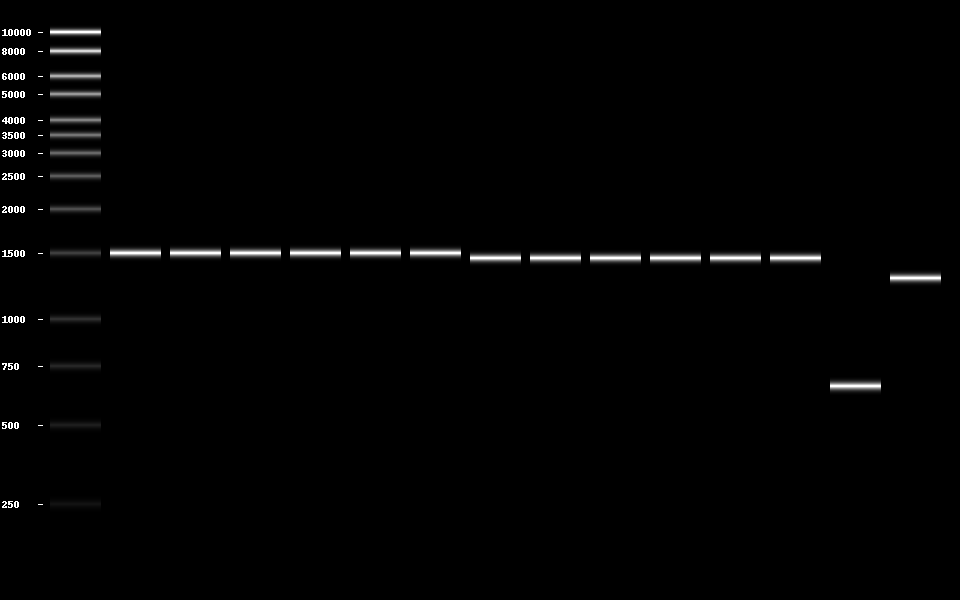

In [73]:
pydna.gel.gel([pydna.ladders.GeneRuler_1kb,*[[band] for band in bands]]) #GeneRuler_1kb_

Actual gel

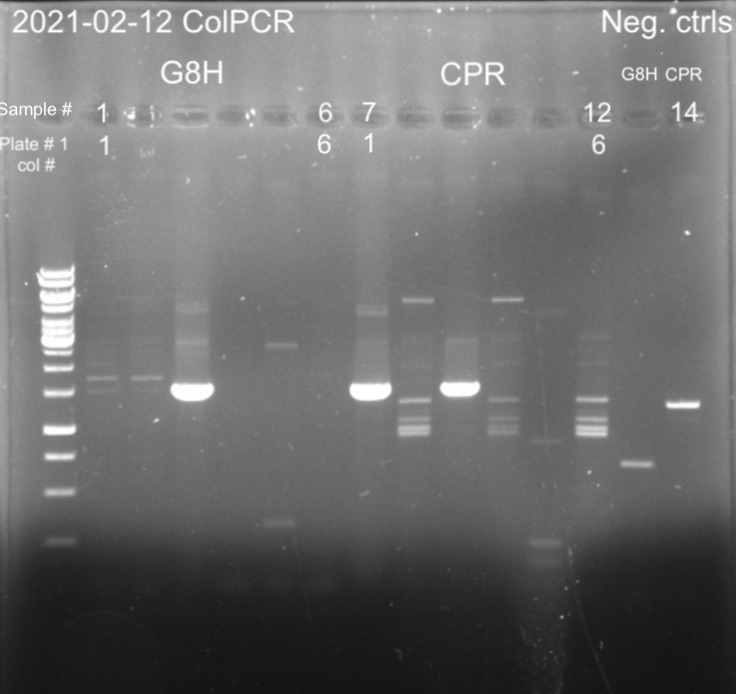

In [74]:
IPython.core.display.Image('G8H_CPR_library/data/05-gel_bioimager_nanophotometer/processed/bioimager/2021-02-12 ColPCR.jpg', width=600)

For plate # 1:
- colony # 1-3 has correct G8H knockout. 
- colony # 1 and 3 has correct CPR knockout
- colony # 1 and 3 have the correct genotype!

Next:
- Use colony # 3